<a href="https://colab.research.google.com/github/NumerousJLs/NumerousJLs/blob/main/FinalBinaryAgeClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IDMB Wikipedia Dataset Faces Only Download


In [ ]:
! wget https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/wiki_crop.tar -P /content/drive/MyDrive/ColabNotebooks/OpenAvenues

In [ ]:
! tar -xvf /content/drive/MyDrive/ColabNotebooks/OpenAvenues/wiki_crop.tar -C /content/drive/MyDrive/ColabNotebooks/OpenAvenues/data/cropfacedata

# Mapping metadata age groundtruth to age buckets 2 (Binary class classifier)

In [ ]:
import scipy.io
from datetime import datetime, timedelta

# Load the .mat file
face_data = scipy.io.loadmat('/content/drive/MyDrive/ColabNotebooks/OpenAvenues/data/cropfacedata/wiki_crop/wiki.mat')

wiki = face_data['wiki'][0][0]
print(wiki.shape)

bucket_0_50 = []
bucket_51_100 = []

for i in range(62328):
    filename = wiki[2][0][i][0]
    birth_year = wiki[0][0][i]
    n_birth_year = datetime.fromordinal(int(birth_year)) + timedelta(days=int(birth_year) % 1) - timedelta(days=366)
    nn_birth_year = n_birth_year.strftime("%Y")
    photo_taken = wiki[1][0][i]
    age_at_photo = int(photo_taken) - int(nn_birth_year)

    if age_at_photo <= 50:
        bucket_0_50.append(filename)
    else:
        bucket_51_100.append(filename)

print(len(bucket_0_50))
print(len(bucket_51_100))

combined_list = [len(bucket_0_50), len(bucket_51_100)]
print(combined_list)

()
49460
12868
[49460, 12868]


# Final Binary Age Classifier: 0-50 or 51-100

In [ ]:
import scipy.io
import cv2
import numpy as np
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Load the .mat file
face_data = scipy.io.loadmat('/content/drive/MyDrive/ColabNotebooks/OpenAvenues/data/cropfacedata/wiki_crop/wiki.mat')

wiki = face_data['wiki'][0][0]

# Step 1: Process and split faces dataset into train and test (80-20 split)
images = []
labels = []

#62328
for i in range(2300):
    filename = wiki[2][0][i][0]
    birth_year = wiki[0][0][i]
    n_birth_year = datetime.fromordinal(int(birth_year)) + timedelta(days=int(birth_year) % 1) - timedelta(days=366)
    nn_birth_year = n_birth_year.strftime("%Y")
    photo_taken = wiki[1][0][i]
    age_at_photo = int(photo_taken) - int(nn_birth_year)

    img = cv2.imread('/content/drive/MyDrive/ColabNotebooks/OpenAvenues/data/cropfacedata/wiki_crop/' + filename, cv2.IMREAD_GRAYSCALE)

    # Step 2: Feature extraction using SIFT
    sift = cv2.SIFT_create()
    kp, des = sift.detectAndCompute(img, None)

    # If there are fewer than 2048 keypoints, we pad the descriptor array with zeros
    if des is None:
        des = np.zeros((2048, 128))
    elif des.shape[0] < 2048:
        des = np.concatenate((des, np.zeros((2048 - des.shape[0], 128))))
    elif des.shape[0] > 2048:
        des = des[:2048, :]

    # Flatten the descriptor array to get a 1D feature vector
    feature_vector = des.flatten()
    feature_vector.reshape(-1, 1)

    # print(np.shape(feature_vector), " 1")
    images.append(feature_vector)
    # print(np.shape(images), " 2")

    # Step 3: Assign binary labels (0 for age 0-50, 1 for age 51-100)
    label = 0 if age_at_photo <= 50 else 1
    labels.append(label)

    # print(np.shape(labels), " 3")

    #print(i, " 4")
    if i % 100 == 0:
      print(i)

print(np.shape(images))
print("Loop Finished")

# Step 4: Split the dataset into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)
print(np.shape(X_train))

print("Dataset Split")

# Step 5: Train a logistic regression classifier
classifier = LogisticRegression(max_iter=1000, random_state=42)
classifier.fit(X_train, y_train)

print("Binary Classifier")

# Step 6: Get accuracy metrics on the test split
y_pred = classifier.predict(X_test)

print(77)

accuracy = accuracy_score(y_test, y_pred)

print(81)

print("Accuracy: {:.2f}%".format(accuracy * 100))

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
(2300, 262144)
Loop Finished
(1840, 262144)
Dataset Split


In [ ]:
count = 0

#Loops through and evalutes contents of feature vectors of X_train
for e in X_train:
    #prints the shape of arrays in X_train
    # print(np.shape(e))

    count += 1
    #prints length of rows in X_train
    #print(len(e))

    #2048 x 128 = 262144, all correct images should have features vectors in X_train of this length
    if len(e) != 262144:
      print(count)
      print(len(e))

# Training Experiment Notes


1.   Wiki birth dates are in special matlab format, used datetime object to convert to integer year
2.   Some images do not have SIFT des, results in NONE error. Fixed by padding. Inital padding if des was NONE was from np.zeroes(1, 128) which resulted in an error because the elif resulted in a numpy array f rom (2048, 128) instead. The np had to be the same size.
3. Feature vector need to be reshaped with .reshape(-1, 1)
4. For unknown reasons the np arrays end with commas and blanks (#, )
5. Errors additionally occured from 2
images that contained more than 2048 keypoints. This was related to 2. when many images had less than 2048 keypoints.
6. Not enough system resources to train model beyond 2300 images, program crashes shortly after.

(2300 successful run)
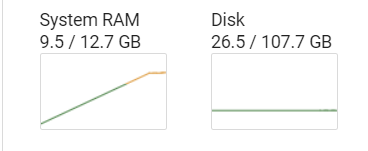

(2400, shortly after crash)
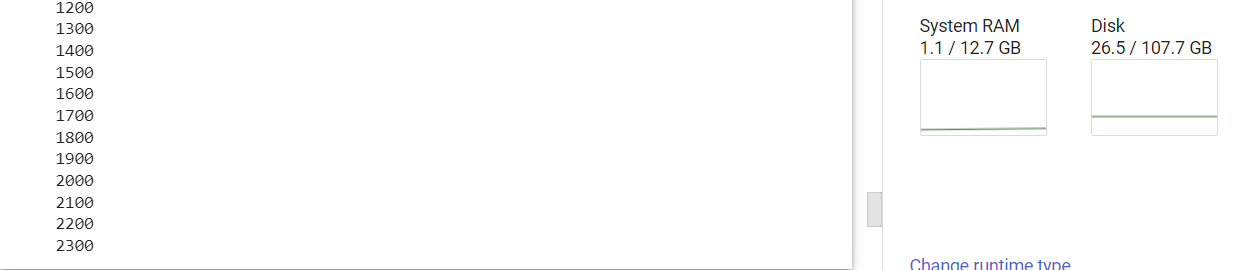

401 - 76.25% accuracy

800 - 77.50% accuracy

2000 - 75.50% accuracy

2300 - 78.26% accuracy